# Virtual bidding in NYISO's markets


In this lab, we will implement a simple virtual trading strategy in New York
ISO's electricity markets. The goal is to maximize profits. We shall train our
model on price data from one year, and implement the strategy on the data from
the next year. How much can you earn with a certain daily budget? Say \$250K?

We will present a trading strategy. You are welcome to try other strategies and compare the gains over multiple runs.

Let's start with customary imports.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import choice
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pickle

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

## Load the day-ahead and real-time prices from 11 zones in New York.

The day-ahead prices are defined every hour. The real-time market runs every 5 minutes. For each zone, an average of
these prices over an hour is published.

Store the list of zones in the variable 'listOfZones'. Also, store the number of options
as the number of zones times the 24 hours available for trading. Finally create another
list containing the option names (zone + hour).

In [5]:
listOfZones = ['CAPITL', 'CENTRL', 'DUNWOD', 'GENESE', 'HUD VL', 'LONGIL', 'MHK VL',
               'MILLWD', 'N.Y.C.', 'NORTH', 'WEST']

nOptions = len(listOfZones) * 24
optionNames = [zone + "_Hour_" + str(t) for zone in listOfZones for t in range(24)]


## Parse the files with DA and RT prices along with DA load forecast.

Define a function that parses three files containing DA and RT prices, along with DA load predictions from a year from all different zones in the list defined before. This function will be used for to both load the data for training the classifiers and testing them. This function has 3 outputs: they are DA prices, difference between DA and RT prices, and finally DA load predictions. The outputs are pandas data frames whose columns are the options, and rows are the days in the year.

In [6]:
def loadNYISOData(year):

    # Open the relevant files for DA prices, RT prices, DA load.

    dfPriceDA = pd.read_csv("DAM_NYISO_Zonal_LBMP_" + str(year) + ".csv")
    dfPriceRT = pd.read_csv("RTM_NYISO_Zonal_LBMP_" + str(year) + ".csv")
    dfLoadDA = pd.read_csv("DAM_NYISO_LoadForecast_" + str(year) + ".csv")

    # Collect the DA and RT prices from each zone from each hour and create a pandas list.
    # The data should have prices and loads from all days of a year, where each day
    # contributes 24 rows, corresponding to each hour.

    priceDA = pd.DataFrame({zone: (dfPriceDA.loc[dfPriceDA['Zone Name'] == zone,
                                                 'DAM Zonal LBMP']).values
                             for zone in listOfZones})
    priceRT = pd.DataFrame({zone: (dfPriceRT.loc[dfPriceRT['Zone Name'] == zone,
                                                 'TWI Zonal LBMP']).values
                             for zone in listOfZones})
    loadDA = pd.DataFrame({zone: (dfLoadDA.loc[dfLoadDA['Zone Name'] == zone,
                                               'DAM Forecast Load']).values
                            for zone in listOfZones})

    numberOfDays = int(len(priceDA.index)/24)

    # Compute the price differences between DA and RT prices for all options on
    # all days of the year. Store it as a pandas data frame where the 24 rows for
    # each day is flattened into one row. This operation essentially allows us to
    # independently think of each zone in each hour as a separate option. Also,
    # reshape the prices for the DA market in the same manner.

    priceDART = pd.DataFrame([priceRT.sub(priceDA).loc[day * 24:
                                                              (day + 1) * 24 - 1,
                              listOfZones].values.flatten()
                              for day in range(numberOfDays)],
                             columns=optionNames)

    priceDA = pd.DataFrame([priceDA.loc[day * 24: (day + 1) * 24 - 1,
                            listOfZones].values.flatten()
                            for day in range(numberOfDays)],
                           columns=optionNames)

    return priceDA, priceDART, loadDA


## Create a function that creates the inputs for training a classifier

Create a function that takes the price and load data and creates two arrays
'X' and 'Y'. Essentially, the rows of 'X' contains all information relevant to
 predicting the sign of the price difference on the various options on the next day.
 It takes as an input, three pandas frames corresponding to the DA prices, price
 differences, and the DA load predictions, and produces three outputs:
 the arrays 'X', 'Y', and the range of days from the year that were used to
 create the data 'X' and 'Y'. This function will be used to both train and
 test classifiers.

In [7]:
def createClassifierIO(priceDA, priceDART, loadDA):

    # Define how many past days of prices to use for classification.

    pastPrices = range(1, 3)

    # Define how many past days of load predictions to use for classification.

    pastLoad = range(1, 3)

    # Define a date range within the year to create the arrays 'X' and 'Y' in a way
    # that past price and load data for the first day is within the date range in the
    # pandas frames passed as inputs.

    rangeOfDays = range(3, len(priceDA.index))

    # 'X' will contain three sets of variables:
    #   1. the DA prices from past days in the list 'pastDays',
    #   2. the differences between DA and RT prices from the same past days,
    #   3. the load predictions from past days in the list 'pastLoad'

    X = [np.concatenate((
        priceDA.loc[[(day - h) for h in pastPrices]].values.flatten(),
        priceDART.loc[[(day - h) for h in pastPrices]].values.flatten(),
        loadDA.loc[[(day - h) for h in pastLoad]].values.flatten()
    )) for day in rangeOfDays]

    # Scale the array 'X' to make its data zero mean and unit variance.
    X = StandardScaler().fit_transform(X)

    # 'Y' will contain zeros and ones, where a one indicates that the price in DA is
    # higher than in RT for a particular option. Recall that an option corresponds to
    # a zone at a particular hour of the day.

    Y = np.array([(priceDART.loc[day].values > 0).astype(int)
                  for day in rangeOfDays])

    # Return the arrays 'X' and 'Y', and finally the range of days from the year that
    # will be utilized for training or testing the classifier.
    return X, Y, rangeOfDays

## Design the training module.
 The training module utilizes a year's worth of data to determine the following for
 each option, i.e., for each zone for each hour of the day:
   1. Classifiers that predict the sign of the difference between DA and RT prices.
   2. Statistics of the mean of the price difference.
   3. A quantile of the day-ahead prices that we will use as our bid for each option.
 You will either train the classifiers here or load them from the folder './Classifiers'.
 Storing the classifiers from time to time allows you to only vary the bidding strategy
 and observe the annual reward rather than having to train the classifiers every time.
 
### Define and train the classifiers or load pre-trained classifiers.

In [8]:
classifiers = []

# We have two options here. Use previous training experience, or learn anew.
useSavedClassifiers = False

if not useSavedClassifiers:

    print("Starting training module...\n")
    trainPriceDA, trainPriceDART, trainLoadDA = loadNYISOData(2015)

    numberOfDays =  int(len(trainPriceDA.index))
    print("Loaded hourly prices from 2015 for %d days." % numberOfDays)

    # We will implement a trading strategy, where we bid a particular quantile of the past
    # DA prices for an option. If you do not know what a quantile means, refer to the Wikipedia
    # article on it. Essentially, a 95% quantile of the DA prices equals that value for which
    # 95% of the DA prices are below it. Store all quantiles starting from 50% in steps of
    # 5% in a dictionary. Store them in a pickle file.

    quantilesToStore = [0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
    offerPrices = trainPriceDA.quantile(q=quantilesToStore).transpose().to_dict()
    pickle.dump(offerPrices, open("./Training/OfferPrices", 'wb'))

    # Calculate the average price spread for each option over the entire year. This will guide
    # us in choosing our portfolio. Store it as a dictionary. Our bid will choose those
    # options that our classifier indicates that they will be profitable and historically they
    # have higher average price differences, indicating that they have higher rate of return.
    # Store them using pickle.

    averagePriceSpread = trainPriceDART.mean(axis=0).transpose().to_dict()
    pickle.dump(averagePriceSpread, open("./Training/AveragePriceSpread", 'wb'))

    # Create the training dataset using the function 'createClassifierIO' on the prices and
    # loads, and store them in 'trainX', and 'trainY'.

    trainX, trainY, _ = createClassifierIO(trainPriceDA, trainPriceDART, trainLoadDA)

    # Define a collection of classifiers, one for each option. You can try different options, such
    # as that based on an SVM, logistic regression, multilayer perceptron based, etc. We will
    # measure training accuracy to indicate how well the classifier works on the training dataset.
    # However, good training accuracy does not always indicate good test performance.
    # Avoid over-fitting.


    classifiers = [MLPClassifier(hidden_layer_sizes=(20, 10), max_iter=200)
                   for _ in range(nOptions)]

    trainingAccuracy = 0

    for ii in range(nOptions):
        classifiers[ii].fit(trainX, trainY[:, ii])
        print("Classifier trained for option " + optionNames[ii])
        trainingAccuracy += classifiers[ii].score(trainX, trainY[:, ii])

        # Store the classifier.
        pickle.dump(classifiers[ii], open("./Training/Classifier_" + optionNames[ii], 'wb'))

    print("\nOverall training accuracy = %1.2f percent." % (100 * trainingAccuracy/nOptions))

    del numberOfDays, trainPriceDA, trainLoadDA, trainPriceDART, trainX, trainY
else:

    # Load the classifiers, the offer prices at various quantiles, and the average price spreads.

    print("Loading previously trained variables...\n")
    classifiers = [pickle.load(open("./Training/Classifier_" + optionNames[ii], 'rb'))
                   for ii in range(nOptions)]
    offerPrices = pickle.load(open("./Training/OfferPrices", 'rb'))
    averagePriceSpread = pickle.load(open("./Training/AveragePriceSpread", 'rb'))

    print("All training variables were loaded successfully...\n")

Starting training module...

Loaded hourly prices from 2015 for 365 days.
Classifier trained for option CAPITL_Hour_0


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option CAPITL_Hour_1
Classifier trained for option CAPITL_Hour_2
Classifier trained for option CAPITL_Hour_3
Classifier trained for option CAPITL_Hour_4
Classifier trained for option CAPITL_Hour_5
Classifier trained for option CAPITL_Hour_6
Classifier trained for option CAPITL_Hour_7


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option CAPITL_Hour_8
Classifier trained for option CAPITL_Hour_9
Classifier trained for option CAPITL_Hour_10
Classifier trained for option CAPITL_Hour_11
Classifier trained for option CAPITL_Hour_12
Classifier trained for option CAPITL_Hour_13
Classifier trained for option CAPITL_Hour_14
Classifier trained for option CAPITL_Hour_15


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option CAPITL_Hour_16
Classifier trained for option CAPITL_Hour_17
Classifier trained for option CAPITL_Hour_18
Classifier trained for option CAPITL_Hour_19
Classifier trained for option CAPITL_Hour_20
Classifier trained for option CAPITL_Hour_21
Classifier trained for option CAPITL_Hour_22


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option CAPITL_Hour_23
Classifier trained for option CENTRL_Hour_0
Classifier trained for option CENTRL_Hour_1
Classifier trained for option CENTRL_Hour_2
Classifier trained for option CENTRL_Hour_3
Classifier trained for option CENTRL_Hour_4
Classifier trained for option CENTRL_Hour_5
Classifier trained for option CENTRL_Hour_6
Classifier trained for option CENTRL_Hour_7
Classifier trained for option CENTRL_Hour_8
Classifier trained for option CENTRL_Hour_9
Classifier trained for option CENTRL_Hour_10
Classifier trained for option CENTRL_Hour_11
Classifier trained for option CENTRL_Hour_12
Classifier trained for option CENTRL_Hour_13
Classifier trained for option CENTRL_Hour_14
Classifier trained for option CENTRL_Hour_15
Classifier trained for option CENTRL_Hour_16
Classifier trained for option CENTRL_Hour_17
Classifier trained for option CENTRL_Hour_18
Classifier trained for option CENTRL_Hour_19
Classifier trained for option CENTRL_Hour_20


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option CENTRL_Hour_21
Classifier trained for option CENTRL_Hour_22
Classifier trained for option CENTRL_Hour_23
Classifier trained for option DUNWOD_Hour_0
Classifier trained for option DUNWOD_Hour_1
Classifier trained for option DUNWOD_Hour_2


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option DUNWOD_Hour_3
Classifier trained for option DUNWOD_Hour_4
Classifier trained for option DUNWOD_Hour_5
Classifier trained for option DUNWOD_Hour_6
Classifier trained for option DUNWOD_Hour_7
Classifier trained for option DUNWOD_Hour_8
Classifier trained for option DUNWOD_Hour_9
Classifier trained for option DUNWOD_Hour_10


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option DUNWOD_Hour_11
Classifier trained for option DUNWOD_Hour_12


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option DUNWOD_Hour_13
Classifier trained for option DUNWOD_Hour_14
Classifier trained for option DUNWOD_Hour_15
Classifier trained for option DUNWOD_Hour_16


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option DUNWOD_Hour_17


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option DUNWOD_Hour_18
Classifier trained for option DUNWOD_Hour_19


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option DUNWOD_Hour_20


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option DUNWOD_Hour_21
Classifier trained for option DUNWOD_Hour_22
Classifier trained for option DUNWOD_Hour_23
Classifier trained for option GENESE_Hour_0
Classifier trained for option GENESE_Hour_1


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option GENESE_Hour_2
Classifier trained for option GENESE_Hour_3
Classifier trained for option GENESE_Hour_4
Classifier trained for option GENESE_Hour_5
Classifier trained for option GENESE_Hour_6
Classifier trained for option GENESE_Hour_7
Classifier trained for option GENESE_Hour_8
Classifier trained for option GENESE_Hour_9
Classifier trained for option GENESE_Hour_10
Classifier trained for option GENESE_Hour_11
Classifier trained for option GENESE_Hour_12


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option GENESE_Hour_13
Classifier trained for option GENESE_Hour_14


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option GENESE_Hour_15
Classifier trained for option GENESE_Hour_16
Classifier trained for option GENESE_Hour_17
Classifier trained for option GENESE_Hour_18
Classifier trained for option GENESE_Hour_19
Classifier trained for option GENESE_Hour_20


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option GENESE_Hour_21
Classifier trained for option GENESE_Hour_22
Classifier trained for option GENESE_Hour_23


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option HUD VL_Hour_0


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option HUD VL_Hour_1
Classifier trained for option HUD VL_Hour_2
Classifier trained for option HUD VL_Hour_3
Classifier trained for option HUD VL_Hour_4
Classifier trained for option HUD VL_Hour_5
Classifier trained for option HUD VL_Hour_6
Classifier trained for option HUD VL_Hour_7
Classifier trained for option HUD VL_Hour_8
Classifier trained for option HUD VL_Hour_9
Classifier trained for option HUD VL_Hour_10
Classifier trained for option HUD VL_Hour_11
Classifier trained for option HUD VL_Hour_12
Classifier trained for option HUD VL_Hour_13
Classifier trained for option HUD VL_Hour_14
Classifier trained for option HUD VL_Hour_15


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option HUD VL_Hour_16
Classifier trained for option HUD VL_Hour_17


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option HUD VL_Hour_18
Classifier trained for option HUD VL_Hour_19
Classifier trained for option HUD VL_Hour_20
Classifier trained for option HUD VL_Hour_21
Classifier trained for option HUD VL_Hour_22
Classifier trained for option HUD VL_Hour_23
Classifier trained for option LONGIL_Hour_0


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_1
Classifier trained for option LONGIL_Hour_2


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_3


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_4


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_5
Classifier trained for option LONGIL_Hour_6
Classifier trained for option LONGIL_Hour_7
Classifier trained for option LONGIL_Hour_8


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_9
Classifier trained for option LONGIL_Hour_10
Classifier trained for option LONGIL_Hour_11


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_12
Classifier trained for option LONGIL_Hour_13
Classifier trained for option LONGIL_Hour_14
Classifier trained for option LONGIL_Hour_15
Classifier trained for option LONGIL_Hour_16


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_17
Classifier trained for option LONGIL_Hour_18
Classifier trained for option LONGIL_Hour_19


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_20
Classifier trained for option LONGIL_Hour_21
Classifier trained for option LONGIL_Hour_22


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_23
Classifier trained for option MHK VL_Hour_0
Classifier trained for option MHK VL_Hour_1
Classifier trained for option MHK VL_Hour_2
Classifier trained for option MHK VL_Hour_3
Classifier trained for option MHK VL_Hour_4
Classifier trained for option MHK VL_Hour_5


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MHK VL_Hour_6
Classifier trained for option MHK VL_Hour_7
Classifier trained for option MHK VL_Hour_8
Classifier trained for option MHK VL_Hour_9
Classifier trained for option MHK VL_Hour_10
Classifier trained for option MHK VL_Hour_11
Classifier trained for option MHK VL_Hour_12


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MHK VL_Hour_13
Classifier trained for option MHK VL_Hour_14


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MHK VL_Hour_15
Classifier trained for option MHK VL_Hour_16
Classifier trained for option MHK VL_Hour_17
Classifier trained for option MHK VL_Hour_18
Classifier trained for option MHK VL_Hour_19
Classifier trained for option MHK VL_Hour_20


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MHK VL_Hour_21


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MHK VL_Hour_22


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MHK VL_Hour_23


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_0


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_1
Classifier trained for option MILLWD_Hour_2
Classifier trained for option MILLWD_Hour_3
Classifier trained for option MILLWD_Hour_4
Classifier trained for option MILLWD_Hour_5
Classifier trained for option MILLWD_Hour_6
Classifier trained for option MILLWD_Hour_7


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_8
Classifier trained for option MILLWD_Hour_9
Classifier trained for option MILLWD_Hour_10


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_11
Classifier trained for option MILLWD_Hour_12


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_13


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_14
Classifier trained for option MILLWD_Hour_15
Classifier trained for option MILLWD_Hour_16


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_17
Classifier trained for option MILLWD_Hour_18
Classifier trained for option MILLWD_Hour_19


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_20
Classifier trained for option MILLWD_Hour_21


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_22
Classifier trained for option MILLWD_Hour_23
Classifier trained for option N.Y.C._Hour_0
Classifier trained for option N.Y.C._Hour_1


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option N.Y.C._Hour_2
Classifier trained for option N.Y.C._Hour_3
Classifier trained for option N.Y.C._Hour_4


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option N.Y.C._Hour_5


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option N.Y.C._Hour_6
Classifier trained for option N.Y.C._Hour_7
Classifier trained for option N.Y.C._Hour_8
Classifier trained for option N.Y.C._Hour_9
Classifier trained for option N.Y.C._Hour_10


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option N.Y.C._Hour_11
Classifier trained for option N.Y.C._Hour_12
Classifier trained for option N.Y.C._Hour_13
Classifier trained for option N.Y.C._Hour_14


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option N.Y.C._Hour_15
Classifier trained for option N.Y.C._Hour_16
Classifier trained for option N.Y.C._Hour_17
Classifier trained for option N.Y.C._Hour_18
Classifier trained for option N.Y.C._Hour_19
Classifier trained for option N.Y.C._Hour_20
Classifier trained for option N.Y.C._Hour_21
Classifier trained for option N.Y.C._Hour_22
Classifier trained for option N.Y.C._Hour_23
Classifier trained for option NORTH_Hour_0


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option NORTH_Hour_1
Classifier trained for option NORTH_Hour_2
Classifier trained for option NORTH_Hour_3
Classifier trained for option NORTH_Hour_4


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option NORTH_Hour_5
Classifier trained for option NORTH_Hour_6


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option NORTH_Hour_7
Classifier trained for option NORTH_Hour_8
Classifier trained for option NORTH_Hour_9
Classifier trained for option NORTH_Hour_10


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option NORTH_Hour_11
Classifier trained for option NORTH_Hour_12
Classifier trained for option NORTH_Hour_13


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option NORTH_Hour_14


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option NORTH_Hour_15
Classifier trained for option NORTH_Hour_16


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option NORTH_Hour_17


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option NORTH_Hour_18


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option NORTH_Hour_19


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option NORTH_Hour_20
Classifier trained for option NORTH_Hour_21
Classifier trained for option NORTH_Hour_22
Classifier trained for option NORTH_Hour_23
Classifier trained for option WEST_Hour_0
Classifier trained for option WEST_Hour_1


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option WEST_Hour_2
Classifier trained for option WEST_Hour_3


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option WEST_Hour_4
Classifier trained for option WEST_Hour_5


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option WEST_Hour_6


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option WEST_Hour_7
Classifier trained for option WEST_Hour_8


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option WEST_Hour_9
Classifier trained for option WEST_Hour_10
Classifier trained for option WEST_Hour_11


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option WEST_Hour_12
Classifier trained for option WEST_Hour_13
Classifier trained for option WEST_Hour_14


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option WEST_Hour_15


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option WEST_Hour_16


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option WEST_Hour_17
Classifier trained for option WEST_Hour_18


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option WEST_Hour_19
Classifier trained for option WEST_Hour_20


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option WEST_Hour_21
Classifier trained for option WEST_Hour_22
Classifier trained for option WEST_Hour_23

Overall training accuracy = 99.97 percent.


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


### Test the classifier's accuracy on test data.

In [9]:
# First, load the test data from NYISO for the year 2016. Again, utilize our function
# named 'loadNYISOData'.

print("Starting the testing module...\n")
testPriceDA, testPriceDART, testLoadDA = loadNYISOData(2016)

# Create the data for the classifier using the function 'createClassifierIO'.
testX, testY, rangeOfDays = createClassifierIO(testPriceDA, testPriceDART, testLoadDA)

# The next step is not useful for implementing the trading strategy, but quickly check how accurate
# your trained classifiers are for the test data. Training accuracy is not always indicative of
# test accuracy.

testingAccuracy = [classifiers[ii].score(testX, testY[:, ii]) for ii in range(nOptions)]
print("Test Accuracy Stats: Min = %.2f%%, Avg = %.2f%%, Max = %.2f%%" %
      (100 * np.min(testingAccuracy),
       100 * np.mean(testingAccuracy),
       100 * np.max(testingAccuracy)))

# Utilize the classifiers to predict the sign of DA - RT prices for each day in 'rangeOfDays' for
# the test data. Store the result in a pandas data frame with columns as the option names and the
# day in year as index.
predictedY = pd.DataFrame(np.column_stack([classifiers[ii].predict(testX) for ii in range(nOptions)]),
                          columns=optionNames, index=rangeOfDays)

Starting the testing module...

Test Accuracy Stats: Min = 48.48%, Avg = 59.08%, Max = 71.07%


## Design and implement the trading strategy. 

We define a fairly simple trading strategy. Define a total budget that you are willing to spend in the DA market. Recall that we only invest in
options where we buy at the DA market and sell at the RT market. When your bid for one unit of an option
clears in the DA market, you have to pay the DA price for that option. There are two possibilities:
  1. Your bid clears: Therefore, your offer price was higher than the DA price.
  2. Your bid does not clear: Then, the DA price was higher than your bid.
In both these cases, the maximum you have to pay is your bid. Therefore, we will enforce that your bids
across all options in a day does not exceed your total budget.
Keep track of how rewards grow (or fall) through the year
as you utilize your strategy. Also, keep track of how much rewards you get from each option. We shall
visualize these results after implementing the trading strategy over the NYISO data for 2016.

Choose the bid prices as a suitable quantile of the historical DA prices. The higher the quantile, the
better your chances are that your bid will be cleared. However, a higher quantile also indicates that
you are budgeting more money for each option, and hence, you will buy fewer options.

In [10]:
dailyBudget = 250000
quantileOffer =0.8

# Keep track of your rewards in each day, a cumulative reward over the year, and a total reward over the
# year. Also, keep track of the total reward from each option. Store them as dictionaries that are
# indexed by day of the year.
reward = {}
cumulativeReward = {}
totalReward = 0
optionReturn = dict((option, 0) for option in optionNames)

# Implement the trading strategy on each day!

for day in rangeOfDays:

    reward[day] = 0

    # Find the options that your classifier says that should be profitable. Store the profitable option
    # names in chosenOptions.
    chosenOptionNumbers = np.ravel(list(np.nonzero(predictedY.loc[day].values)))
    if np.size(chosenOptionNumbers) == 0:
        continue
    chosenOptions = [optionNames[i] for i in chosenOptionNumbers]

    # Design the portfolio based on average price spreads. Our strategy is that as long as you have not
    # exceeded your daily budget, pick an option from the list of 'chosenOptions' probabilistically, where
    # the probability of choosing it is proportional to exponential(historical rewards of that option). That
    # is, a historically profitable option is chosen more often than one that is not. Keep sampling and
    # decreasing your budget with each bid.

    # Start with an empty portfolio.

    portfolio = dict((option, 0) for option in chosenOptions)

    # Calculate the probabilities of choosing each option among the list 'chosenOptions'. Recall that
    # 'chosenOptions' contains the options that your classifier indicates as being profitable.
    priceSpreads = [1.0 * averagePriceSpread[option] for option in chosenOptions]
    probabilityOptions = [np.exp(p) for p in priceSpreads]
    probabilityOptions /= np.sum(probabilityOptions)

    # Start with your daily budget.
    budget = dailyBudget

    # Sampling among the profitable options and bid based on them.
    while budget > np.median([offerPrices[quantileOffer][option] for option in chosenOptions]):

        optionToBuy = choice(chosenOptions, p=probabilityOptions)

        if budget >= offerPrices[quantileOffer][optionToBuy]:
            portfolio[optionToBuy] += 1
            budget -= offerPrices[quantileOffer][optionToBuy]

    # Compute the reward from the day. Go through each of the options you have decided to buy.
    # If the DA price is lower than the bid price, then your bid is cleared. For each option you
    # have bought, you get a reward equal to the DA - RT price.

    for option in chosenOptions:
        if testPriceDA.at[day, option] < offerPrices[quantileOffer][option]:
            rewardOptionDay = testPriceDART.at[day, option] * portfolio[option]
            optionReturn[option] += rewardOptionDay
            reward[day] += rewardOptionDay

    totalReward += reward[day]

    # Calculate the cumulative reward in millions of dollars.
    cumulativeReward[day] = totalReward/1000000

    print("Day " + str(day) + ": Reward (in $) = " + "{0:,.0f}".format(reward[day]))

print("Total money earned over the year (in $) = " + "{0:,.0f}".format(totalReward))

Day 3: Reward (in $) = -78,167
Day 4: Reward (in $) = 7,634
Day 5: Reward (in $) = 25,547
Day 6: Reward (in $) = -24,472
Day 7: Reward (in $) = -11,875
Day 8: Reward (in $) = -45,404
Day 9: Reward (in $) = -33,003
Day 10: Reward (in $) = -112,131
Day 11: Reward (in $) = -42,902
Day 12: Reward (in $) = -47,524
Day 13: Reward (in $) = -30,407
Day 14: Reward (in $) = -34,518
Day 15: Reward (in $) = -2,260
Day 16: Reward (in $) = 43,342
Day 17: Reward (in $) = -57,871
Day 18: Reward (in $) = -20,983
Day 19: Reward (in $) = 24,224
Day 20: Reward (in $) = 4,541
Day 21: Reward (in $) = 61,898
Day 22: Reward (in $) = 85,985
Day 23: Reward (in $) = 30,982
Day 24: Reward (in $) = -86,513
Day 25: Reward (in $) = -82,537
Day 26: Reward (in $) = -19,078
Day 27: Reward (in $) = -7,967
Day 28: Reward (in $) = -8,374
Day 29: Reward (in $) = -32,421
Day 30: Reward (in $) = -54,368
Day 31: Reward (in $) = -29,247
Day 32: Reward (in $) = -7,703
Day 33: Reward (in $) = -93,327
Day 34: Reward (in $) = 5,39

Day 259: Reward (in $) = -40,649
Day 260: Reward (in $) = -28,209
Day 261: Reward (in $) = 76,332
Day 262: Reward (in $) = -4,687
Day 263: Reward (in $) = -63,478
Day 264: Reward (in $) = -61,773
Day 265: Reward (in $) = -40,267
Day 266: Reward (in $) = -75,928
Day 267: Reward (in $) = -13,112
Day 268: Reward (in $) = -23,856
Day 269: Reward (in $) = -84,148
Day 270: Reward (in $) = -57,613
Day 271: Reward (in $) = -11,962
Day 272: Reward (in $) = -70,122
Day 273: Reward (in $) = -44,605
Day 274: Reward (in $) = 18,228
Day 275: Reward (in $) = 24,104
Day 276: Reward (in $) = -9,203
Day 277: Reward (in $) = 96,457
Day 278: Reward (in $) = 113,228
Day 279: Reward (in $) = -43,975
Day 280: Reward (in $) = 14,367
Day 281: Reward (in $) = -13,064
Day 282: Reward (in $) = -1,429
Day 283: Reward (in $) = -2,501
Day 284: Reward (in $) = 8,482
Day 285: Reward (in $) = -61,291
Day 286: Reward (in $) = -68,554
Day 287: Reward (in $) = -65,713
Day 288: Reward (in $) = 11,968
Day 289: Reward (in $)

### Task1:  Visualize the rewards (25 points)

We would like to plot the cumulative reward over the year 2016. By cumulative reward on a particular date, we mean the total reward from the start of the year till that date.

Also, plot a heat map of the returns from each option. 

#### Fill in the missing lines below.

ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of ticklabels (11).

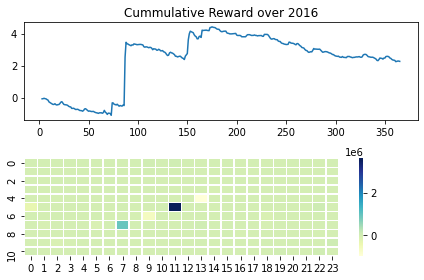

In [11]:
# Plot the cumulative reward over the year 2016. Also, plot a heat map of the returns from
# each option.

fig, axs = plt.subplots(2, 1, tight_layout=True)
axs = axs.ravel()


## Enter code here where you plot in axs[0].
keys=cumulativeReward.keys();
values=cumulativeReward.values();
axs[0].plot(list(keys), list(values))
axs[0].set_title('Cummulative Reward over 2016')

axs[1] = sns.heatmap(np.reshape(list(optionReturn.values()), (len(listOfZones), 24)),
                     linewidth=0.5,
                     cmap="YlGnBu")
axs[1].set_yticklabels(listOfZones, rotation=0)
axs[1].set_xticklabels(range(24), rotation=90)
axs[1].set_title('Returns on different options')
plt.show()


### Task 2: Choosing a classifier (25 points)

We used a multilayer perceptron classifier. Your task is to try out SVM and logistic regression classifiers, and explore which one leads to more profits. Use the relevant functions from 'sklearn'.

**Logistic Regression yielded the most total money over the year, second was the MLP classifier and third was the SVM classifier.**

In [ ]:
#SVM
classifiers = []
useSavedClassifiers = False
if not useSavedClassifiers:
    trainPriceDA, trainPriceDART, trainLoadDA = loadNYISOData(2015)
    numberOfDays =  int(len(trainPriceDA.index))
    quantilesToStore = [0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
    offerPrices = trainPriceDA.quantile(q=quantilesToStore).transpose().to_dict()
    pickle.dump(offerPrices, open("./Training/OfferPrices", 'wb'))
    averagePriceSpread = trainPriceDART.mean(axis=0).transpose().to_dict()
    pickle.dump(averagePriceSpread, open("./Training/AveragePriceSpread", 'wb'))
    trainX, trainY, _ = createClassifierIO(trainPriceDA, trainPriceDART, trainLoadDA)
    classifiers = [SVC()
                   for _ in range(nOptions)]
    trainingAccuracy = 0
    for ii in range(nOptions):
        classifiers[ii].fit(trainX, trainY[:, ii])
        trainingAccuracy += classifiers[ii].score(trainX, trainY[:, ii])
        pickle.dump(classifiers[ii], open("./Training/Classifier_" + optionNames[ii], 'wb'))
    print("\nOverall training accuracy of SVM= %1.2f percent." % (100 * trainingAccuracy/nOptions))
    del numberOfDays, trainPriceDA, trainLoadDA, trainPriceDART, trainX, trainY
    
dailyBudget = 250000
quantileOffer =0.8
reward = {}
cumulativeReward = {}
totalReward = 0
optionReturn = dict((option, 0) for option in optionNames)
for day in rangeOfDays:
    reward[day] = 0
    chosenOptionNumbers = np.ravel(list(np.nonzero(predictedY.loc[day].values)))
    if np.size(chosenOptionNumbers) == 0:
        continue
    chosenOptions = [optionNames[i] for i in chosenOptionNumbers]
    portfolio = dict((option, 0) for option in chosenOptions)
    priceSpreads = [1.0 * averagePriceSpread[option] for option in chosenOptions]
    probabilityOptions = [np.exp(p) for p in priceSpreads]
    probabilityOptions /= np.sum(probabilityOptions)
    budget = dailyBudget
    while budget > np.median([offerPrices[quantileOffer][option] for option in chosenOptions]):
        optionToBuy = choice(chosenOptions, p=probabilityOptions)
        if budget >= offerPrices[quantileOffer][optionToBuy]:
            portfolio[optionToBuy] += 1
            budget -= offerPrices[quantileOffer][optionToBuy]
    for option in chosenOptions:
        if testPriceDA.at[day, option] < offerPrices[quantileOffer][option]:
            rewardOptionDay = testPriceDART.at[day, option] * portfolio[option]
            optionReturn[option] += rewardOptionDay
            reward[day] += rewardOptionDay
    totalReward += reward[day]
    cumulativeReward[day] = totalReward/1000000
print("Total money earned over the year (in $) using SVM = " + "{0:,.0f}".format(totalReward))

#Logistic Regression
classifiers = []
useSavedClassifiers = False
if not useSavedClassifiers:
    trainPriceDA, trainPriceDART, trainLoadDA = loadNYISOData(2015)
    numberOfDays =  int(len(trainPriceDA.index))
    quantilesToStore = [0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
    offerPrices = trainPriceDA.quantile(q=quantilesToStore).transpose().to_dict()
    pickle.dump(offerPrices, open("./Training/OfferPrices", 'wb'))
    averagePriceSpread = trainPriceDART.mean(axis=0).transpose().to_dict()
    pickle.dump(averagePriceSpread, open("./Training/AveragePriceSpread", 'wb'))
    trainX, trainY, _ = createClassifierIO(trainPriceDA, trainPriceDART, trainLoadDA)
    classifiers = [LogisticRegression()
                   for _ in range(nOptions)]
    trainingAccuracy = 0
    for ii in range(nOptions):
        classifiers[ii].fit(trainX, trainY[:, ii])
        trainingAccuracy += classifiers[ii].score(trainX, trainY[:, ii])
        pickle.dump(classifiers[ii], open("./Training/Classifier_" + optionNames[ii], 'wb'))
    print("Overall training accuracy of Logistic Regression= %1.2f percent." % (100 * trainingAccuracy/nOptions))
    del numberOfDays, trainPriceDA, trainLoadDA, trainPriceDART, trainX, trainY
    
dailyBudget = 250000
quantileOffer =0.8
reward = {}
cumulativeReward = {}
totalReward = 0
optionReturn = dict((option, 0) for option in optionNames)
for day in rangeOfDays:
    reward[day] = 0
    chosenOptionNumbers = np.ravel(list(np.nonzero(predictedY.loc[day].values)))
    if np.size(chosenOptionNumbers) == 0:
        continue
    chosenOptions = [optionNames[i] for i in chosenOptionNumbers]
    portfolio = dict((option, 0) for option in chosenOptions)
    priceSpreads = [1.0 * averagePriceSpread[option] for option in chosenOptions]
    probabilityOptions = [np.exp(p) for p in priceSpreads]
    probabilityOptions /= np.sum(probabilityOptions)
    budget = dailyBudget
    while budget > np.median([offerPrices[quantileOffer][option] for option in chosenOptions]):
        optionToBuy = choice(chosenOptions, p=probabilityOptions)
        if budget >= offerPrices[quantileOffer][optionToBuy]:
            portfolio[optionToBuy] += 1
            budget -= offerPrices[quantileOffer][optionToBuy]
    for option in chosenOptions:
        if testPriceDA.at[day, option] < offerPrices[quantileOffer][option]:
            rewardOptionDay = testPriceDART.at[day, option] * portfolio[option]
            optionReturn[option] += rewardOptionDay
            reward[day] += rewardOptionDay
    totalReward += reward[day]
    cumulativeReward[day] = totalReward/1000000
print("Total money earned over the year (in $) using Logistic Regression = " + "{0:,.0f}".format(totalReward))

### Task 3: Quantile (25 points)

For the best classifier, try different quanltile choices from the following list: 0.70, 0.75, 0.80, 0.85, 0.90, 0.95. Rank them in terms of profits (low to high). 

How do you expect the quantile to affect the portfolio? 

**Setting quantile to 0.70 and using Logistic Regression yields the maximum money earned over the year. Increasing quantile decreases total money earned over the year. The higher the quantile the lower the probability that our bid gets cleared. 1-Quantile just shows the risk associated with winning or losing. If the quantile is high and the bid does not clear, you neither make money nor lose any. But if the quantile is low and the bid clears, you might or might not make money depending on the difference between the day-ahead price and real-time price and this is how it affects the portfolio. The following is the rank in increasing order of profits: 0.95, 0.90, 0.85, 0.80, 0.75, 0.70.**

In [ ]:
classifiers = []
useSavedClassifiers = False
if not useSavedClassifiers:
    trainPriceDA, trainPriceDART, trainLoadDA = loadNYISOData(2015)
    numberOfDays =  int(len(trainPriceDA.index))
    quantilesToStore = [0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
    offerPrices = trainPriceDA.quantile(q=quantilesToStore).transpose().to_dict()
    pickle.dump(offerPrices, open("./Training/OfferPrices", 'wb'))
    averagePriceSpread = trainPriceDART.mean(axis=0).transpose().to_dict()
    pickle.dump(averagePriceSpread, open("./Training/AveragePriceSpread", 'wb'))
    trainX, trainY, _ = createClassifierIO(trainPriceDA, trainPriceDART, trainLoadDA)
    classifiers = [LogisticRegression()
                   for _ in range(nOptions)]
    trainingAccuracy = 0
    for ii in range(nOptions):
        classifiers[ii].fit(trainX, trainY[:, ii])
        trainingAccuracy += classifiers[ii].score(trainX, trainY[:, ii])
        pickle.dump(classifiers[ii], open("./Training/Classifier_" + optionNames[ii], 'wb'))
    print("Overall training accuracy of Logistic Regression= %1.2f percent." % (100 * trainingAccuracy/nOptions))
    del numberOfDays, trainPriceDA, trainLoadDA, trainPriceDART, trainX, trainY
    
dailyBudget = 250000
quantileOffer =[0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
reward = {}
cumulativeReward = {}
optionReturn = dict((option, 0) for option in optionNames)
for quantile in quantileOffer:
    totalReward = 0
    for day in rangeOfDays:
        reward[day] = 0
        chosenOptionNumbers = np.ravel(list(np.nonzero(predictedY.loc[day].values)))
        if np.size(chosenOptionNumbers) == 0:
            continue
        chosenOptions = [optionNames[i] for i in chosenOptionNumbers]
        portfolio = dict((option, 0) for option in chosenOptions)
        priceSpreads = [1.0 * averagePriceSpread[option] for option in chosenOptions]
        probabilityOptions = [np.exp(p) for p in priceSpreads]
        probabilityOptions /= np.sum(probabilityOptions)
        budget = dailyBudget
        while budget > np.median([offerPrices[quantile][option] for option in chosenOptions]):
            optionToBuy = choice(chosenOptions, p=probabilityOptions)
            if budget >= offerPrices[quantile][optionToBuy]:
                portfolio[optionToBuy] += 1
                budget -= offerPrices[quantile][optionToBuy]
        for option in chosenOptions:
            if testPriceDA.at[day, option] < offerPrices[quantile][option]:
                rewardOptionDay = testPriceDART.at[day, option] * portfolio[option]
                optionReturn[option] += rewardOptionDay
                reward[day] += rewardOptionDay
        totalReward += reward[day]
        cumulativeReward[day] = totalReward/1000000
    print("Total money earned over the year (in $) using Logistic Regression and quantile =", quantile, "is " + "{0:,.0f}".format(totalReward))

### Task 4: Daily budget (25 points)

We used a daily budget of 250,000. Try different budgets, let's say, 100,000, 150,000, 200,000, and 300,000. Rank them in terms of profits (low to high). Fix the quantile to the one that led to maximum profits in the previous task. 

**As the budget increases, the total money earned over the year also increases. So the ranks of budgets in increasing order is 100,000 < 150,000 < 200,000 < 300,000.**

In [ ]:
classifiers = []
useSavedClassifiers = False
if not useSavedClassifiers:
    trainPriceDA, trainPriceDART, trainLoadDA = loadNYISOData(2015)
    numberOfDays =  int(len(trainPriceDA.index))
    quantilesToStore = [0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
    offerPrices = trainPriceDA.quantile(q=quantilesToStore).transpose().to_dict()
    pickle.dump(offerPrices, open("./Training/OfferPrices", 'wb'))
    averagePriceSpread = trainPriceDART.mean(axis=0).transpose().to_dict()
    pickle.dump(averagePriceSpread, open("./Training/AveragePriceSpread", 'wb'))
    trainX, trainY, _ = createClassifierIO(trainPriceDA, trainPriceDART, trainLoadDA)
    classifiers = [LogisticRegression()
                   for _ in range(nOptions)]
    trainingAccuracy = 0
    for ii in range(nOptions):
        classifiers[ii].fit(trainX, trainY[:, ii])
        trainingAccuracy += classifiers[ii].score(trainX, trainY[:, ii])
        pickle.dump(classifiers[ii], open("./Training/Classifier_" + optionNames[ii], 'wb'))
    print("Overall training accuracy of Logistic Regression= %1.2f percent." % (100 * trainingAccuracy/nOptions))
    del numberOfDays, trainPriceDA, trainLoadDA, trainPriceDART, trainX, trainY
    
dailyBudget = [100000,150000, 200000, 300000]
quantileOffer =0.70
reward = {}
cumulativeReward = {}
optionReturn = dict((option, 0) for option in optionNames)
for db in dailyBudget:
    totalReward = 0
    for day in rangeOfDays:
        reward[day] = 0
        chosenOptionNumbers = np.ravel(list(np.nonzero(predictedY.loc[day].values)))
        if np.size(chosenOptionNumbers) == 0:
            continue
        chosenOptions = [optionNames[i] for i in chosenOptionNumbers]
        portfolio = dict((option, 0) for option in chosenOptions)
        priceSpreads = [1.0 * averagePriceSpread[option] for option in chosenOptions]
        probabilityOptions = [np.exp(p) for p in priceSpreads]
        probabilityOptions /= np.sum(probabilityOptions)
        budget = db
        while budget > np.median([offerPrices[quantileOffer][option] for option in chosenOptions]):
            optionToBuy = choice(chosenOptions, p=probabilityOptions)
            if budget >= offerPrices[quantileOffer][optionToBuy]:
                portfolio[optionToBuy] += 1
                budget -= offerPrices[quantileOffer][optionToBuy]
        for option in chosenOptions:
            if testPriceDA.at[day, option] < offerPrices[quantileOffer][option]:
                rewardOptionDay = testPriceDART.at[day, option] * portfolio[option]
                optionReturn[option] += rewardOptionDay
                reward[day] += rewardOptionDay
        totalReward += reward[day]
        cumulativeReward[day] = totalReward/1000000
    print("Total money earned over the year (in $) using Logistic Regression and budget =", db, "is " + "{0:,.0f}".format(totalReward))

### Task 6: Beat the algorithm! (15 points, bonus) 

Make changes to increase the profits further! The people with the top 15 total profits will get additional points. Exaplain what did for improvement and how much profits you made. Do not exceed the 250,000 budget!

#### (comments here, add a new code cell below)

### Task 7: Implement a different trading strategy (10 points, bonus) 

Implement a different trading strategy, explain it and report its outcomes. If the rewards are comparable to the one discussed in class, and you can clearly explain the logic behind you strategy, you get additional 25 points. If your strategy leads to having profits among the top 20, then you automatically completed Task 6 too! 

#### (comments here, add a new code cell below)